In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import datetime

In [2]:
# Project time frame
start_date = "2020-01-01"
end_date = "2025-05-01"

# Benchmark index
benchmark_symbol = "^GSPC"

# Top 10 symbols from each sector (replace with your actual tickers if needed)
sectors = {
    "Technology": ["AAPL"],
    # "Technology": ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'INTC', 'AMD'],
    # "Communication": ["GOOGL", "META", "NFLX", "TMUS", "DIS", "VZ", "T", "CHTR", "CMCSA", "WBD"],
    # "Health": ["JNJ", "PFE", "ABBV", "LLY", "MRK", "TMO", "BMY", "UNH", "ABT", "CVS"],
    # "Financials": ["JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "USB", "BK", "SCHW"],
    # "Defensive": ["PG", "KO", "PEP", "WMT", "COST", "CL", "MO", "KMB", "MDLZ", "KR"],
    # "Cyclical": ["AMZN", "HD", "LOW", "MCD", "NKE", "SBUX", "BKNG", "TGT", "EBAY", "GM"],
    # "Property": ["PLD", "AMT", "CCI", "EQIX", "DLR"benchmark_symbol "SPG", "O", "PSA", "VTR", "EXR"],
    # "Benchmark": [benchmark_symbol]
}

# Flatten list of all tickers
all_symbols = [symbol for group in sectors.values() for symbol in group]

### Load from CSV

In [3]:
# Load dataset from CSV
import os

if os.path.exists("stock_sector_data.csv"):
    stock_df = pd.read_csv("stock_sector_data.csv", parse_dates=["Date"])
    print("Loaded dataset from CSV.")
else:
    print("CSV file not found. Please run the download step.")
    
# Drop any rows that are not in sectors dictionary
stock_df = stock_df[stock_df["Symbol"].isin(all_symbols)]
    

# Drop any rows with symbol that match the benchmark symbol
stock_df = stock_df[stock_df["Symbol"] != benchmark_symbol]


Loaded dataset from CSV.


### Feature Engineering — Add Technical Indicators


In [4]:
def add_technical_indicators(df):
    result = []

    for symbol in df["Symbol"].unique():
        sub = df[df["Symbol"] == symbol].sort_values("Date").copy()

        # Momentum: past 1-week and 4-week returns
        sub["Return_1w"] = sub["Close"].pct_change(1*7)
        sub["Return_4w"] = sub["Close"].pct_change(4*7)

        # Volatility: Rolling std dev
        sub["Volatility_4w"] = sub["Close"].rolling(window=4*7).std()
        
        # Moving averages
        sub['MA5'] = sub['Close'].rolling(window=5*7).mean()
        sub['MA20'] = sub['Close'].rolling(window=20*7).mean()
        sub['MA50'] = sub['Close'].rolling(window=50*7).mean()
        
        # Volume indicators
        sub['Volume_Change'] = sub['Volume'].pct_change(periods=7)
        sub['Volume_MA5'] = sub['Volume'].rolling(window=5*7).mean()
        
        # MACD
        sub["MACD"] = MACD(close=sub["Close"]).macd()
        sub["MACD_Signal"] = MACD(close=sub["Close"]).macd_signal()

        # RSI
        sub["RSI"] = RSIIndicator(close=sub["Close"], window=14).rsi()

        # SMAbenchmark_symbol
        # Bollinger Bands
        bb = BollingerBands(close=sub["Close"], window=20)
        sub["BB_Upper"] = bb.bollinger_hband()
        sub["BB_Lower"] = bb.bollinger_lband()

        result.append(sub)

    features_df = pd.concat(result).reset_index(drop=True)
    return features_df

features_df = add_technical_indicators(stock_df)
features_df = features_df.dropna()
features_df.head()


Date        Open        High         Low       Close    Volume  \
349 2021-05-21  125.251107  125.427490  122.693562  122.909142  79295400   
350 2021-05-24  123.477488  125.368700  123.408895  124.545578  63092900   
351 2021-05-25  125.251110  125.741069  123.781257  124.349602  72009500   
352 2021-05-26  124.408403  124.829762  123.879255  124.300613  56575900   
353 2021-05-27  123.898844  125.074724  122.566176  122.762154  94625600   

    Symbol      Sector  Return_1w  Return_4w  ...         MA5        MA20  \
349   AAPL  Technology   0.021667  -0.065365  ...  127.237405  123.940324   
350   AAPL  Technology   0.017044  -0.035705  ...  127.276979  124.071726   
351   AAPL  Technology  -0.004315  -0.054903  ...  127.302288  124.202356   
352   AAPL  Technology   0.004593  -0.052881  ...  127.278963  124.321003   
353   AAPL  Technology   0.003444  -0.069321  ...  127.142926  124.397250   

           MA50  Volume_Change    Volume_MA5      MACD  MACD_Signal  \
349  102.046795      -0.293093  9.054538e+07 -1.085024    -0.699238   
350  102.194879      -0.404004  8.981514e+07 -0.970629    -0.753516   
351  102.344424      -0.120956  8.958195e+07 -0.885577    -0.779928   
352  102.492188      -0.237980  8.881364e+07 -0.812756    -0.786494   
353  102.636533       0.493863  8.897881e+07 -0.869166    -0.803028   

           RSI    BB_Upper    BB_Lower  
349  44.598384  132.743991  119.145692  
350  48.516382  131.848909  119.316471  
351  48.077875  130.896198  119.557567  
352  47.961180  130.004679  119.811807  
353  44.322775  128.974092  120.061052  

[5 rows x 21 columns]

### Create Outperformance Label

In [5]:
def create_outperformance_labels(features_df, benchmark_df):
    # Calculate future return for S&P 500
    benchmark_df["Benchmark_Return_Next"] = benchmark_df["Close"].pct_change().shift(-1)

    # Ensure 'Date' columns are of the same type
    features_df["Date"] = pd.to_datetime(features_df["Date"])
    benchmark_df["Date"] = pd.to_datetime(benchmark_df["Date"])

    # Merge benchmark return into stock data
    df = features_df.merge(benchmark_df[["Date", "Benchmark_Return_Next"]], on="Date", how="left")
    
    # Calculate benchmark return this week
    df["Benchmark_Return"] = df["Benchmark_Return_Next"].shift(1)

    # Calculate stock return this week and next week
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df["Stock_Return_Next"] = df.groupby("Symbol")[price_col].pct_change().shift(-1)
    df["Stock_Return"] = df["Stock_Return_Next"].shift(1)
    
    df.dropna(inplace=True)
    
    # Calculate this week's pct return over to the benchmark
    df["Pct_Difference"] = (df["Stock_Return"] - df["Benchmark_Return"]) / df["Benchmark_Return"]

    # Label = 1 if stock outperforms benchmark, else 0
    df["Label"] = (df["Stock_Return_Next"] > df["Benchmark_Return_Next"]).astype(int)

    return df

# Load benchmark data from CSV
benchmark_df = pd.read_csv("stock_sector_data.csv", usecols=["Date", "Symbol", "Close"])
benchmark_df = benchmark_df[benchmark_df["Symbol"] == benchmark_symbol].reset_index(drop=True)

labeled_df = create_outperformance_labels(features_df, benchmark_df)
labeled_df.tail()


Date        Open        High         Low       Close    Volume  \
984 2025-04-23  206.000000  208.000000  202.800003  204.600006  52929200   
985 2025-04-24  204.889999  208.830002  202.940002  208.369995  47311000   
986 2025-04-25  206.369995  209.750000  206.199997  209.279999  38222300   
987 2025-04-28  210.000000  211.500000  207.460007  210.139999  38743100   
988 2025-04-29  208.690002  212.240005  208.369995  211.210007  36827600   

    Symbol      Sector  Return_1w  Return_4w  ...  MACD_Signal        RSI  \
984   AAPL  Technology   0.032551  -0.024227  ...    -7.505812  49.043627   
985   AAPL  Technology   0.028886  -0.023982  ...    -6.983917  51.384054   
986   AAPL  Technology   0.035322  -0.022056  ...    -6.361112  51.957654   
987   AAPL  Technology   0.081690  -0.011989  ...    -5.679489  52.527701   
988   AAPL  Technology   0.072241  -0.018723  ...    -4.966715  53.270632   

       BB_Upper    BB_Lower  Benchmark_Return_Next  Benchmark_Return  \
984  232.077236  173.799767               0.020259          0.016661   
985  230.282384  174.278619               0.007373          0.020259   
986  227.985550  175.118453               0.000641          0.007373   
987  226.843364  175.484639               0.005802          0.000641   
988  224.918351  176.317652               0.001480          0.005802   

     Stock_Return_Next  Stock_Return  Pct_Difference  Label  
984           0.018426      0.024332        0.460382      0  
985           0.004367      0.018426       -0.090476      0  
986           0.004109      0.004367       -0.407681      1  
987           0.005092      0.004109        5.413746      0  
988           0.006108      0.005092       -0.122455      1  

[5 rows x 27 columns]

### Train/Test Split & Preprocessing

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    # Drop rows where the label is missing (NaN due to shifting)
    df = df.dropna(subset=["Label"])
    
    # Fill remaining missing values with median (safe for numeric features)
    df = df.fillna(df.median(numeric_only=True))

    # Keep only numeric feature columns
    # exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    exclude_cols = ['Date', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    feature_columns = [col for col in df.columns if col not in exclude_cols and df[col].dtype != 'object']
    
    X = df[feature_columns]
    y = df["Label"].astype(int)  # Ensure label is int

    # Optional: Scaling (not strictly necessary for Random Forest)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [7]:
# Split the data: train up to 2023, test after
train_data = labeled_df[labeled_df["Date"] < "2024-11-01"]
test_data = labeled_df[labeled_df["Date"] >= "2024-11-01"]

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

In [8]:
# Shape of the data
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (867, 21), Labels shape: (867,)
Testing data shape: (121, 21), Labels shape: (121,)


### Train Random KMeans

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score

# Train K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# Predict cluster labels
y_pred = kmeans.predict(X_test)

# Evaluation: Metrics
print("Cluster Centers:")
print(kmeans.cluster_centers_)

print("Silhouette Score:")
print(silhouette_score(X_test, y_pred))  

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


Cluster Centers:
[[-0.68346721 -0.68003262 -0.68764917 -0.6832137   0.36952811 -0.0125483
  -0.04601945  0.01723582 -0.69983661 -0.69839687 -0.63338012 -0.03157593
   0.68226203 -0.11063508 -0.12310094 -0.03927665 -0.67189061 -0.70200731
  -0.03349084  0.00115253 -0.00150162]
 [ 0.89670899  0.89220279  0.90219571  0.89637637 -0.48482088  0.01646337
   0.06037752 -0.02261339  0.91818563  0.9162967   0.83099472  0.04142762
  -0.89512778  0.14515323  0.16150843  0.05153097  0.88152048  0.92103359
   0.04393998 -0.00151212  0.00197013]]
Silhouette Score:
0.20480821297003665
F1 Score: 0.4838709677419355


### Feature Importance Plot

In [10]:

from kmeans_interp.kmeans_feature_imp import KMeansInterp

exclude_cols = ['Date', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

# Get feature importances and namesX_train
feature_columns = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']

kms = KMeansInterp(
	n_clusters=2,
	ordered_feature_names=feature_columns, 
	feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(train_data[feature_columns].values)

kms.feature_importances_[0]

[('Volume_MA5', np.float64(65273862.68551237)),
 ('Volume', np.float64(56273510.07067134)),
 ('BB_Upper', np.float64(181.99218502844775)),
 ('High', np.float64(176.627371561806)),
 ('Close', np.float64(175.29173809900726)),
 ('Open', np.float64(175.1535656354634)),
 ('Low', np.float64(173.77508412601966)),
 ('MA5', np.float64(171.91204321416924)),
 ('MA20', np.float64(165.0541805139279)),
 ('BB_Lower', np.float64(164.78629369643295)),
 ('MA50', np.float64(155.9638004641314)),
 ('RSI', np.float64(55.352257271480035)),
 ('Volatility_4w', np.float64(5.323659130096546)),
 ('MACD', np.float64(1.3216849761772824)),
 ('MACD_Signal', np.float64(1.2830581927612807)),
 ('Pct_Difference', np.float64(0.918132253909812)),
 ('Volume_Change', np.float64(0.04162485932053245)),
 ('Return_4w', np.float64(0.035773859668963556)),
 ('Return_1w', np.float64(0.008698642495705537)),
 ('Stock_Return', np.float64(0.0008808922565312881)),
 ('Benchmark_Return', np.float64(0.0007829375633385302))]

In [11]:
top_6_features = [feature[0] for feature in kms.feature_importances_[0][:6]]
top_6_features

['Volume_MA5', 'Volume', 'BB_Upper', 'High', 'Close', 'Open']

### Correlation Analysis

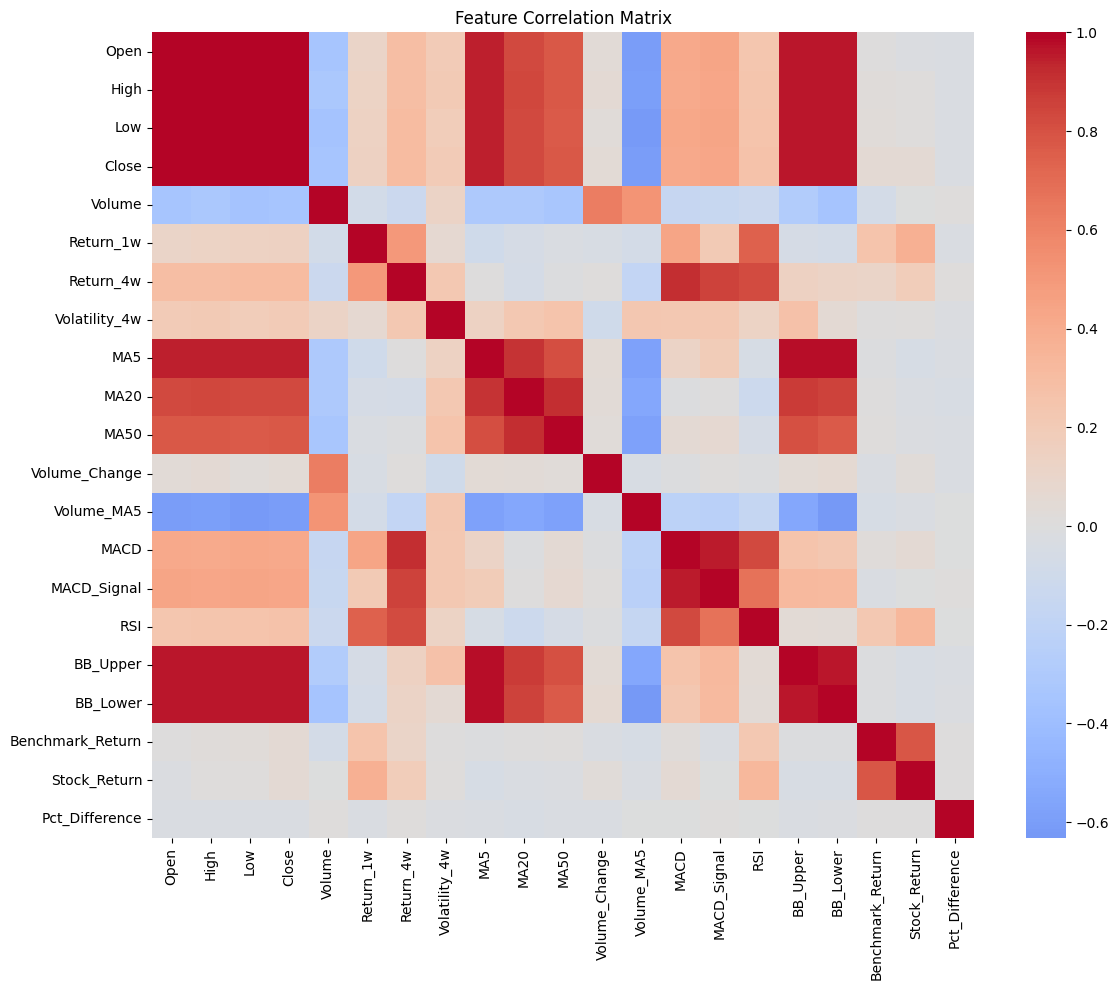

In [12]:
# Compute correlation matrix on the training features
exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

numeric_cols = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
corr_matrix = train_data[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Reduce Multicollinearity

In [13]:
selected_features = top_6_features

### Train/Test Split & Preprocessing after Reduce Multicollinearity

In [14]:
from itertools import combinations
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
import time

import matplotlib.pyplot as plt

# Store the best combination and its score
best_combination = None
best_score = 0
scores = []

# Function to evaluate a combination of features
def evaluate_combination(combo):
    # Preprocess data with the current combination of features
    start_time = time.time()
    X_train_combo = train_data[list(combo)]
    X_test_combo = test_data[list(combo)]

    kmeans = KMeans(n_clusters=2, random_state=42)
    # Train the model
    kmeans.fit(X_train_combo)

    # Predict and evaluate
    y_pred_combo = kmeans.predict(X_test_combo)
    # Check if there are at least two distinct clusters
    if len(set(y_pred_combo)) > 1:
        score = silhouette_score(X_test_combo, y_pred_combo)
        print(f"Combination: {combo}, Silhouette Score: {score}")
    else:
        score = float('-inf')  # Assign a very low score for invalid combinations
        print(f"Combination: {combo}, Silhouette Score: Not valid (only one cluster)")

    print(f"Time taken: {time.time() - start_time:.2f} seconds")

    return combo, score

# Run combinations in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combination)(combo)
    for r in range(1, len(selected_features) + 1)
    for combo in combinations(selected_features, r)
)


Combination: ('Volume',), Silhouette Score: 0.7774176577857426
Time taken: 0.04 seconds
Combination: ('High',), Silhouette Score: Not valid (only one cluster)
Time taken: 0.03 seconds
Combination: ('Volume', 'High'), Silhouette Score: 0.7774176577838537
Time taken: 0.01 seconds
Combination: ('Volume', 'Close'), Silhouette Score: 0.777417657783809
Time taken: 0.01 seconds
Combination: ('Volume', 'Open'), Silhouette Score: 0.7774176577838816
Time taken: 0.01 seconds
Combination: ('BB_Upper', 'High'), Silhouette Score: Not valid (only one cluster)
Time taken: 0.01 seconds
Combination: ('BB_Upper', 'Close'), Silhouette Score: Not valid (only one cluster)
Time taken: 0.01 seconds
Combination: ('Volume_MA5',), Silhouette Score: Not valid (only one cluster)
Time taken: 0.03 seconds
Combination: ('BB_Upper', 'Open'), Silhouette Score: Not valid (only one cluster)
Time taken: 0.01 seconds
Combination: ('High', 'Close'), Silhouette Score: Not valid (only one cluster)
Time taken: 0.01 seconds
Com

In [15]:
# Collect and rank results
scores = sorted(results, key=lambda x: x[1], reverse=True)
best_combination, best_score = scores[0]

best_combination = np.array(best_combination)

print(f"Best combination: {best_combination}")
print(f"Best F1 Score: {best_score}")

Best combination: ['Volume']
Best F1 Score: 0.7774176577857426


In [16]:
results.sort(key=lambda x: x[1], reverse=True)
results

[(('Volume',), np.float64(0.7774176577857426)),
 (('Volume', 'BB_Upper'), np.float64(0.7774176577852178)),
 (('Volume', 'Open'), np.float64(0.7774176577838816)),
 (('Volume', 'High'), np.float64(0.7774176577838537)),
 (('Volume', 'Close'), np.float64(0.777417657783809)),
 (('Volume', 'BB_Upper', 'Open'), np.float64(0.7774176577833571)),
 (('Volume', 'BB_Upper', 'High'), np.float64(0.7774176577833293)),
 (('Volume', 'BB_Upper', 'Close'), np.float64(0.7774176577832844)),
 (('Volume', 'High', 'Open'), np.float64(0.777417657781993)),
 (('Volume', 'Close', 'Open'), np.float64(0.7774176577819483)),
 (('Volume', 'High', 'Close'), np.float64(0.7774176577819204)),
 (('Volume', 'BB_Upper', 'High', 'Open'), np.float64(0.7774176577814684)),
 (('Volume', 'BB_Upper', 'Close', 'Open'), np.float64(0.7774176577814237)),
 (('Volume', 'BB_Upper', 'High', 'Close'), np.float64(0.7774176577813957)),
 (('Volume', 'High', 'Close', 'Open'), np.float64(0.7774176577800596)),
 (('Volume', 'BB_Upper', 'High', 'Clo

### Apply best combination

In [17]:
# Apply the specified hyperparameters and best feature combination
kmeans = KMeans(n_clusters=2, random_state=42)

# exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next', 'Open', 'High', 'Low']
# select_features = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']

# Use the best combination of features
# select_features = best_combination
select_features = ['Volume', 'BB_Upper']

# Create test and train sets
train_data = labeled_df[labeled_df["Date"] < "2025-01-01"]
test_data = labeled_df[labeled_df["Date"] >= "2025-01-01"]

In [18]:
print(train_data['Label'].value_counts())
print(test_data['Label'].value_counts())

Label
1    479
0    429
Name: count, dtype: int64
Label
0    42
1    38
Name: count, dtype: int64


In [19]:
# Create a new DataFrame with the selected features
X_train = train_data[select_features]
X_test = test_data[select_features]
y_train = train_data["Label"]
y_test = test_data["Label"]

# Train the model
km_model = kmeans.fit(X_train)

# Make predictions
y_pred = kmeans.predict(X_test)

# Generate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.19      0.30        42
           1       0.50      0.89      0.64        38

    accuracy                           0.53        80
   macro avg       0.58      0.54      0.47        80
weighted avg       0.59      0.53      0.46        80



Train with all data except last row of Symbol

In [20]:
# Create train and test sets
train_data = labeled_df.iloc[:-1]  # All rows except the last one
test_data = labeled_df.iloc[-1:]  # Only the last row

In [21]:
print(train_data['Label'].value_counts())
print(test_data['Label'].value_counts())

Label
1    516
0    471
Name: count, dtype: int64
Label
1    1
Name: count, dtype: int64


### Hyperparameter Tuning

In [22]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score

# Define a custom scorer for silhouette score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

param_grid = {
    'n_clusters': range(2, 10),
    'init': ['k-means++', 'random'],
    'n_init': [5, 10, 15],
    'max_iter': [100, 200, 300, 400, 500],
    'tol': [0.0001, 0.001, 0.01],
    'algorithm': ['lloyd', 'elkan'],
    'random_state': [0, 42, 100]
}

grid = GridSearchCV(KMeans(), param_grid, cv=3, scoring=make_scorer(silhouette_scorer), n_jobs=-1)
grid.fit(X_train)



/home/kamin/Documents/CPE 232 Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kamin/Documents/CPE 232 Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/kamin/Documents/CPE 232 Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kamin/Documents/CPE 232 Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/

GridSearchCV(cv=3, estimator=KMeans(), n_jobs=-1,
             param_grid={'algorithm': ['lloyd', 'elkan'],
                         'init': ['k-means++', 'random'],
                         'max_iter': [100, 200, 300, 400, 500],
                         'n_clusters': range(2, 10), 'n_init': [5, 10, 15],
                         'random_state': [0, 42, 100],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring=make_scorer(silhouette_scorer, response_method='predict'))

In [23]:
print("Best parameters found: ", grid.best_params_)

Best parameters found:  {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2, 'n_init': 5, 'random_state': 0, 'tol': 0.0001}


###  Cross-Validation Evaluation

In [24]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(km_model, X_train, y_train, cv=TimeSeriesSplit(n_splits=5), scoring='f1')

# Print the results
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

Cross-Validation F1 Scores: [0.40944882 0.2020202  0.70742358 0.125      0.10416667]
Mean F1 Score: 0.30961185367410654
